My transformer notebook. 

In [1]:
import requests
import unicodedata
import math
import numpy as np
import pandas as pd
from dataclasses import dataclass
import json
from collections import Counter, defaultdict
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from jaxtyping import Int, Float
import matplotlib.pyplot as plt
import tqdm
import transformers
import transformer_lens
from datasets import load_dataset

c:\Python\Python_3_10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

if(torch.cuda.is_available() == True):
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
#tinystorydata = load_dataset("roneneldan/TinyStories")

In [4]:
# necessary auto-reload for development on local machine
%load_ext autoreload
%autoreload 2

In [5]:
@dataclass(kw_only=True)
class GPTConfig:
    """Here we configure set up the dimensions of
    our model. Defaults dimensions come from gpt-2 model"""
    d_model: int = 16 # dimension of residual stream, the vectors it internally passes around 
    d_vocab: int = 50257 # defines the number of different tokens that can be represented as inputs (vocabulary size)
    n_context: int = 1024 # maximum sequence length (context window size)
    n_layer: int = 2 # number of transformer blocks 
    n_head: int = 4 # number of attenton heads 
    head_bias: bool = False # whether to use bias in attention heads
    mlp_expansion: int = 4 # expansion factor in MLP

    # make sure that model dimension is divisible by number of heads
    @property
    def d_head(self):
        assert self.d_model % self.n_head == 0, f"'{self.d_model = }' must be divisible by '{self.n_head = }': {self.d_model} % {self.n_head} == {self.d_model % self.n_head}"
        return self.d_model // self.n_head
    
    @property
    def params_shapes(self) -> dict:
        return dict(
            token_embeddings=(self.d_vocab, self.d_model),
            positional_embeddings=(self.n_context, self.d_model),
            attention_weights=(
                self.n_layer,
                4,
                self.d_model,
                self.d_model,
            ),
            attention_bias=(
                self.n_layer,
                int(self.head_bias),
                self.d_model,
            ),
            mlp_weights=(
                self.n_layer,
                2,
                self.d_model,
                self.d_model * self.mlp_expansion,
            ),
            mlp_bias=(
                self.n_layer,
                self.mlp_expansion + 1,
                self.d_model,
            ),
            block_layernorms=(
                self.n_layer,
                2,
                2,
                self.d_model,
            ),
            output_layernorm=(2, self.d_model),
            lm_head=(self.d_model, self.d_vocab),
        )
    
    @property
    def params_numel(self) -> dict:
        return {
            k: int(torch.tensor(v).prod())
            for k, v in self.params_shapes.items()
        }

    @property
    def n_params(self) -> int:
        return sum([v for v in self.params_numel.values()])
    



In [6]:
class AttentionHead(nn.Module):

    def __init__(self, config: GPTConfig):
        super().__init__()

        # store dimensions
        self.n_head: int = config.n_head
        self.d_model: int = config.d_model
        self.n_context: int = config.n_context

        # concatenating the outputs of the heads should give us d_model, but this check is done in GPTConfig
        self.d_head: int = config.d_head
        self.head_bias: bool = config.head_bias

        # coefficient for scaling the dot product of the query and key in the attention calculation
        self.sqrt_dim: float = 1.0 / math.sqrt(self.d_head)
    

        # key, query, value projections
        self.W_K: nn.Module = nn.Linear(self.d_model, self.d_head, bias = self.head_bias)
        self.W_Q: nn.Module = nn.Linear(self.d_model, self.d_head, bias = self.head_bias)
        self.W_V: nn.Module = nn.Linear(self.d_model, self.d_head, bias = self.head_bias)

        # causal mask to ensure that attention is only applied to the left in the input sequence
        # `register_buffer` means it's not a trainable parameter
        self.register_buffer(
            "causal_mask", 
            torch.tril(
                torch.ones(config.n_context, config.n_context)
            )
            .view(1, 1, config.n_context, config.n_context)
        )

    def forward(self, x: Float[torch.Tensor, "batch n_ctx d_model"]) -> Float[torch.Tensor, "batch n_ctx d_head"]:
        assert x.ndim == 3, str(x.shape)
        B, n_ctx, d_model = x.shape # batch size, sequence length, embedding dimensionality (d_model)
        assert d_model == self.d_model, str(x.shape)
        # assert n_ctx == self.n_context, str(x.shape)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q: Float[torch.Tensor, "batch n_ctx d_head"] = self.W_Q(x)
        k: Float[torch.Tensor, "batch n_ctx d_head"] = self.W_K(x)
        v: Float[torch.Tensor, "batch n_ctx d_head"] = self.W_V(x)

        # self-attention
        # (B, n_ctx, d_h) x (B, d_h, n_ctx) -> (B, n_ctx, n_ctx)
        att = (q @ k.transpose(-2, -1)) * self.sqrt_dim
        
        # autoregressive (causal) masking
        att = att.masked_fill(
            self.causal_mask[:,:n_ctx,:n_ctx] == 0, 
            float('-inf'),
        )


        # softmax
        att = F.softmax(att, dim=-1)

        # apply the self-attention to the values
        # (B, n_ctx, n_ctx) x (B, n_ctx, d_h) -> (B, n_ctx, d_h)
        output = att @ v
        return output.view(B, n_ctx, self.d_head)



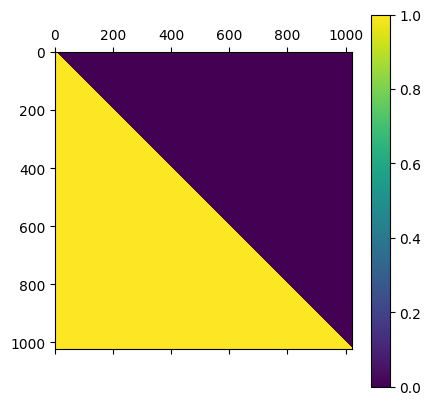

In [7]:
A: AttentionHead = AttentionHead(GPTConfig())

plt.matshow(A.causal_mask[0, 0].cpu().numpy())
plt.colorbar()
plt.show()

In [8]:
cfg: GPTConfig = GPTConfig(
	n_context=128,
	d_model=64,
	n_head=4,
)
A: AttentionHead = AttentionHead(cfg)
print(A)

x = torch.randn(1, cfg.n_context, cfg.d_model)
print(f"{cfg.d_head = }")
print(f"{x.shape = }")
print(f"{A(x).shape = }")

AttentionHead(
  (W_K): Linear(in_features=64, out_features=16, bias=False)
  (W_Q): Linear(in_features=64, out_features=16, bias=False)
  (W_V): Linear(in_features=64, out_features=16, bias=False)
)
cfg.d_head = 16
x.shape = torch.Size([1, 128, 64])
A(x).shape = torch.Size([1, 128, 16])


In [9]:
class MultiHeadedAttention(nn.Module):
	def __init__(self, config: GPTConfig):
		super().__init__()
		self.n_head: int = config.n_head
		self.d_head: int = config.d_model // config.n_head
		self.d_model: int = config.d_model

		# attention heads
		self.attention_heads: nn.ModuleList = nn.ModuleList([
			AttentionHead(config) 
			for _ in range(self.n_head)
		])

		# output projection
		self.W_O: nn.Module = nn.Linear(self.d_model, self.d_model)


	def forward(self, x: Float[torch.Tensor, "batch n_ctx d_model"]) -> Float[torch.Tensor, "batch n_ctx d_model"]:
		assert x.ndim == 3, str(x.shape)
		# apply all attention heads and concatenate their outputs
		# note: in reality, you would do this all in one tensor
		# we split the attention heads up to make it easier to understand
		att = torch.cat(
			[
				head(x) 
				for head in self.attention_heads
			],
			dim=-1,
		)
		assert len(att.shape) == 3, str(att.shape)

		# output projection
		# (B, n_ctx, d_head * n_head) -> (B, n_ctx, d_model)
		output = self.W_O(att)
		assert output.shape == x.shape, str(output.shape)
		return output


In [10]:
class TransformerBlock(nn.Module):
	def __init__(self, config: GPTConfig):
		super().__init__()

		# layernorm, attention, another layernorm, mlp
		self.ln_1: nn.Module = nn.LayerNorm(config.d_model)
		self.attention: nn.Module = MultiHeadedAttention(config)
		self.ln_2: nn.Module = nn.LayerNorm(config.d_model)
		self.mlp: nn.Module = nn.Sequential(
			nn.Linear(config.d_model, config.mlp_expansion * config.d_model),
			nn.GELU(),
			nn.Linear(config.mlp_expansion * config.d_model, config.d_model),
		)

	def forward(self, x: Float[torch.Tensor, "batch n_ctx d_model"]) -> Float[torch.Tensor, "batch n_ctx d_model"]:
		assert x.ndim == 3, str(x.shape)
		x = x + self.attention(self.ln_1(x))
		assert x.ndim == 3, str(x.shape)
		x = x + self.mlp(self.ln_2(x))
		assert x.ndim == 3, str(x.shape)
		return x

In [11]:
class GPT(nn.Module):
	def __init__(self, config: GPTConfig, tokenizer: transformers.PreTrainedTokenizer):
		super().__init__()

		self.config: GPTConfig = config
		self.tokenizer: transformers.PreTrainedTokenizer = tokenizer
		assert config.d_vocab >= tokenizer.vocab_size

		# token and positional embeddings
		self.token_embeddings: nn.Module = nn.Embedding(config.d_vocab, config.d_model)
		self.positional_embeddings: nn.Module = nn.Embedding(config.n_context, config.d_model)

		# transformer
		self.transformer_blocks: nn.ModuleList = nn.ModuleList([
			TransformerBlock(config) 
			for _ in range(config.n_layer)
		])

		# language model head
		self.ln_f: nn.Module = nn.LayerNorm(config.d_model)
		self.lm_head: nn.Module = nn.Linear(config.d_model, config.d_vocab, bias=False)

	def forward(
			self, 
			x: Int[torch.Tensor, "batch n_ctx"],
			targets: Int[torch.Tensor, "batch n_ctx"]|None = None,
		) -> tuple:
		"""returns a tuple of (logits, loss) where loss=None if targets is None"""
		assert x.ndim == 2, str(x.shape)

		# calculate token and positional embeddings and sum them
		x_res: Float[torch.Tensor, "batch n_ctx d_model"] = self.token_embeddings(x) + self.positional_embeddings(torch.arange(x.size(1), device=x.device))

		assert x_res.ndim == 3, str(x.shape)

		# transformer blocks
		for i, block in enumerate(self.transformer_blocks):
			x_res = block(x_res)

		# language model head
		logits: Float[torch.Tensor, "batch n_ctx d_vocab"] = self.lm_head(self.ln_f(x_res))

		loss = None
		if targets is not None:
			loss = F.cross_entropy(
				logits.transpose(1, 2),
				targets,
				ignore_index=-1,
			)

		return logits, loss
	
	@torch.no_grad()
	def generate(
		self,
		prompt: str|list[int]|Int[torch.Tensor, "* n_ctx"],
		max_new_tokens: int = 128,
		temperature: float = 1.0,
	) -> str:

		# convert prompt to string and tensor versions
		prompt_str: str
		prompt_tensor: Int[torch.Tensor, "1 n_ctx"]
		if isinstance(prompt, str):
			prompt_str = prompt
			prompt_tensor = torch.tensor(self.tokenizer.encode(prompt_str), dtype=torch.long).unsqueeze(0) # add batch dim
		elif isinstance(prompt, list):
			prompt_str = self.tokenizer.decode(prompt)
			prompt_tensor = torch.tensor(prompt, dtype=torch.long).unsqueeze(0) # add batch dim
		elif isinstance(prompt, torch.Tensor):
			if prompt.ndim == 1:
				prompt = prompt.unsqueeze(0) # add batch dim
			assert prompt.ndim == 2

			prompt_str = self.tokenizer.decode(prompt[0].tolist())
			prompt_tensor = prompt
		else:
			raise ValueError(f"prompt must be a string, list of ints, or PyTorch tensor")
		
		# check tensor dims
		assert isinstance(prompt_str, str) 
		assert isinstance(prompt_tensor, torch.Tensor)
		assert prompt_tensor.ndim == 2 
		assert prompt_tensor.shape[0] == 1

		#  device
		prompt_tensor = prompt_tensor.to(self.device)

		# pad the prompt if necessary
		if prompt_tensor.shape[1] < self.config.n_context:
			prompt_tensor = F.pad(prompt_tensor, (0, self.config.n_context - prompt_tensor.shape[1]), value=self.tokenizer.pad_token_id)

		assert prompt_tensor.shape[1] == self.config.n_context

		# iterate until max_new_tokens is reached, or an end-of-sequence token is generated
		completions: list[int] = list()
		for _ in range(max_new_tokens):
			# truncate sequence to block size
			prompt_len: int = prompt_tensor.shape[1]
			if prompt_len > self.config.n_context:
				prompt_tensor = prompt_tensor[:, -self.config.n_context:]

			# forward the model to get the logits for the index in the sequence
			logits, _ = self(prompt_tensor)

			# pluck the logits at the final step and scale by desired temperature
			logits = logits[:, -1, :] / temperature

			# apply softmax to convert logits to (normalized) probabilities
			probs = F.softmax(logits, dim=-1)

			# sample from the distribution
			idx_next = torch.multinomial(probs, num_samples=1)

			# append sampled index to the running sequence and continue
			idx = torch.cat((prompt_tensor, idx_next), dim=1)

			# append the token to the running completions
			completions.append(int(idx_next[0, 0]))

			# check if end of sequence token is generated
			if idx_next == self.tokenizer.eos_token_id:
				break

		return self.tokenizer.decode(completions)

	@property
	def n_params(self) -> int:
		return sum(p.numel() for p in self.parameters())
	
	@property
	def device(self) -> torch.device:
		device_set: set[torch.device] = set(p.device for p in self.parameters())
		assert len(device_set) == 1, device_set
		return next(iter(device_set))

In [12]:
text_data_full = load_dataset("roneneldan/TinyStories")

Repo card metadata block was not found. Setting CardData to empty.


In [13]:
text_data = text_data_full["train"]
print(text_data[1,2])

{'text': ['Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leaves that were falling. Beep liked how the leaves fall and wanted to play with them. Beep drove under the tree and watched the leaves fall on him. He laughed and beeped his horn.\n\nBeep played with the falling leaves all day. When it was time to go home, Beep knew he needed more fuel. He went to the fuel place and got more healthy fuel. Now, Beep was ready to go fast and play again the next day. And Beep lived happily ever after.', 'One day, a little fish named Fin was swimming near the shore. He saw a big crab and wanted to be friends. "Hi, I am Fin. Do you want to play?" asked the little fish. The crab looked at Fin and said, "No, I don\'t want to play. I am cold and I don\'t feel fine."\n\nFin felt sa

In [14]:
text_data = "\n\n".join(text_data['text'])

In [15]:
text_data = text_data[:1000000]

In [16]:
#make a text dataset like text_data but filled strictly with "a" characters
# text_data_a = "a" * 10000

In [17]:
class TextDataset(Dataset):
	def __init__(
			self, 
			text: str, 
			tokenizer: transformers.PreTrainedTokenizer,
			n_context: int,
			ensure_n_context_match: bool = True,
		):
		# add 1 to n_context to account for the target token
		n_context += 1

		# tokenize the text
		tokenized_text: list[int] = tokenizer.encode(text)
		self.total_tokens: int = len(tokenized_text)

		# trim the last tokens to make sure the length is a multiple of n_context
		if ensure_n_context_match:
			tokenized_text = tokenized_text[:-(len(tokenized_text) % n_context)]
			self.total_tokens = len(tokenized_text)

		# split the text into examples of length n_context
		# this means that text will often start in the middle of a sentence
		# in reality, we might want to do this a bit smarter
		self.examples: list[list[int]] = [
			tokenized_text[i:i+n_context] 
			for i in range(0, len(tokenized_text), n_context)
		]

	def __len__(self) -> int:
		return len(self.examples)
	
	def __getitem__(self, i: int) -> Float[torch.Tensor, "n_ctx"]:
		return torch.tensor(self.examples[i], dtype=torch.long)
	
	def example_lengths(self) -> Counter[int]:
		return Counter(len(ex) for ex in self.examples)

In [18]:
def train(
	model: GPT,
	text: str,
	optimizer: torch.optim.Optimizer,
	device: torch.device = ("cuda" if torch.cuda.is_available() else "cpu"),
	batch_size: int = 8,
	max_batches: int|None = None,
	print_interval: int = 100,
	epochs: int = 1,
) -> tuple[GPT, list[dict]]:
	
	# move model to device
	print(f"moving model to device: {device}")
	model.to(device)
	
	# set up data
	print(f"setting up dataset from text of length {len(text)}")
	dataset: TextDataset = TextDataset(
		text=text, 
		tokenizer=model.tokenizer, 
		n_context=model.config.n_context,
	)
	print(f"\tset up dataset with {len(dataset)} examples, example lengths: {dataset.example_lengths()}")

	print(f"setting up dataloader from {len(dataset)} examples")
	dataloader: DataLoader = DataLoader(
		dataset, 
		batch_size=batch_size, 
		shuffle=True,
	)
	print(f"\tset up dataloader with {len(dataloader)} batches of size {batch_size}")

	# set up training loop
	print("training...")
	training_records: list[dict] = list()
	model.train()

	for epoch in range(epochs):
		print(f"Epoch {epoch + 1}/{epochs}\n")
		i: int; batch: Float[torch.Tensor, "batch n_ctx"]
		for i, batch in tqdm.tqdm(
			enumerate(dataloader),
			total=len(dataloader),
			desc="Training",
		):
			# move batch to device
			batch = batch.to(device)
			
			# break if we've reached the maximum number of batches
			if max_batches is not None and i > max_batches:
				break

			# forward pass
			logits, loss = model(
				batch[:, :-1],
				targets=batch[:, 1:], # the targets are just the input, offset by one
			)

			# backward pass
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			# record progress
			training_records.append({
				"batch": i,
				"loss": loss.item(),
			})

			if i % print_interval == 0:
				print(f"Batch {i}, Loss: {loss.item()}\n")

	return model, training_records



In [19]:
from muutils.misc import shorten_numerical_to_str

In [20]:
# we want to ensure our vocab dimension is the same as the tokenizer's vocab size
TOKENIZER: transformers.PreTrainedTokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
print(f"{TOKENIZER.vocab_size = }")

# set up a config for a small model
CONFIG: GPTConfig = GPTConfig(
	d_model=8,
	d_vocab=TOKENIZER.vocab_size,
	n_context=128,
	n_layer=2,
	n_head=4,
)

# initialize the model
MODEL: GPT = GPT(CONFIG, TOKENIZER)
print(f"MODEL.n_params = {shorten_numerical_to_str(MODEL.n_params)}")
print(f"MODEL.n_params = {MODEL.n_params}")

# optimizer
OPTIMIZER: torch.optim.Optimizer = torch.optim.AdamW(MODEL.parameters(), lr=1e-2)


TOKENIZER.vocab_size = 50257
MODEL.n_params = 807K
MODEL.n_params = 806848


In [21]:
MODEL_TRAINED, training_history = train(
	model=MODEL,
	text=text_data,
	optimizer=OPTIMIZER,
	device=("cuda" if torch.cuda.is_available() else "cpu"),
	batch_size=32,
	max_batches=None,
	print_interval=100,
	epochs=100,
)

moving model to device: cuda
setting up dataset from text of length 1000000


Token indices sequence length is longer than the specified maximum sequence length for this model (250081 > 1024). Running this sequence through the model will result in indexing errors


	set up dataset with 1938 examples, example lengths: Counter({129: 1938})
setting up dataloader from 1938 examples
	set up dataloader with 61 batches of size 32
training...
Epoch 1/100



Training:   3%|▎         | 2/61 [00:02<01:00,  1.02s/it]

Batch 0, Loss: 10.992903709411621



Training: 100%|██████████| 61/61 [00:10<00:00,  6.07it/s]


Epoch 2/100



Training:   2%|▏         | 1/61 [00:00<00:07,  7.90it/s]

Batch 0, Loss: 5.886844635009766



Training: 100%|██████████| 61/61 [00:07<00:00,  7.67it/s]


Epoch 3/100



Training:   2%|▏         | 1/61 [00:00<00:07,  7.84it/s]

Batch 0, Loss: 5.226143836975098



Training: 100%|██████████| 61/61 [00:08<00:00,  7.61it/s]


Epoch 4/100



Training:   2%|▏         | 1/61 [00:00<00:07,  7.78it/s]

Batch 0, Loss: 4.865655422210693



Training: 100%|██████████| 61/61 [00:08<00:00,  7.56it/s]


Epoch 5/100



Training:   2%|▏         | 1/61 [00:00<00:07,  7.52it/s]

Batch 0, Loss: 4.640615940093994



Training: 100%|██████████| 61/61 [00:08<00:00,  7.41it/s]


Epoch 6/100



Training:   2%|▏         | 1/61 [00:00<00:07,  7.55it/s]

Batch 0, Loss: 4.400755882263184



Training: 100%|██████████| 61/61 [00:08<00:00,  7.38it/s]


Epoch 7/100



Training:   2%|▏         | 1/61 [00:00<00:08,  7.32it/s]

Batch 0, Loss: 4.165530204772949



Training: 100%|██████████| 61/61 [00:08<00:00,  7.13it/s]


Epoch 8/100



Training:   2%|▏         | 1/61 [00:00<00:08,  6.87it/s]

Batch 0, Loss: 4.249005317687988



Training: 100%|██████████| 61/61 [00:08<00:00,  7.09it/s]


Epoch 9/100



Training:   2%|▏         | 1/61 [00:00<00:09,  6.53it/s]

Batch 0, Loss: 4.162419319152832



Training: 100%|██████████| 61/61 [00:11<00:00,  5.31it/s]


Epoch 10/100



Training:   2%|▏         | 1/61 [00:00<00:08,  6.92it/s]

Batch 0, Loss: 3.976008415222168



Training: 100%|██████████| 61/61 [00:37<00:00,  1.62it/s]


Epoch 11/100



Training:   2%|▏         | 1/61 [00:00<00:09,  6.33it/s]

Batch 0, Loss: 4.0603413581848145



Training: 100%|██████████| 61/61 [00:17<00:00,  3.42it/s]


Epoch 12/100



Training:   2%|▏         | 1/61 [00:01<01:28,  1.48s/it]

Batch 0, Loss: 4.04439640045166



Training: 100%|██████████| 61/61 [00:19<00:00,  3.06it/s]


Epoch 13/100



Training:   2%|▏         | 1/61 [00:00<00:08,  6.75it/s]

Batch 0, Loss: 3.904994249343872



Training:  36%|███▌      | 22/61 [00:15<00:26,  1.45it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(MODEL_TRAINED, "model.pt")

In [23]:
print(MODEL.generate("Once"))

 Every Sally
 What
 It

 A Let
 But
 She Sara That
 She 
 From As She
 They They Seeâ
 He They And She
 " He They I This You You Tweet
 You I They The His I  He She
 Come You Afterâ

 He They What
 It Help How You
 Every
 Helpâ He Now Give Whis
 B She Once
 They We

 Come

 You She
 They
 She Don They
 years Spider What These But I Jane
 Suddenly mammal You He Help
 They They They It�

 They  We I
 They It He " That
